In [1]:
%%html
<style>
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunss.otf');
    }
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunsx.otf');
        font-weight: bold;
    }
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunsi.otf');
        font-style: italic, oblique;
    }
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunbxo.otf');
        font-weight: bold;
        font-style: italic, oblique;
    }
    .text_cell { font-family: "Computer Modern", "Palatino", "Palatino Linotype", serif; }
    .code_cell:first-child { display: none; } 
    h1, h2, h3, h4 { text-align: center; }
</style>

# Chaotic Behavior of the Triple Pendulum
## A Computational Approach

#### Rachel Bass and Cory McCartan

In [56]:
%%capture

# Set-up and formatting

%pylab inline
from scipy.integrate import odeint 
from scipy.interpolate import UnivariateSpline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # print out value of variable without needing print statement
%config InlineBackend.figure_format = "retina"  # higher-def plots
figsize(16, 7) # larger plots

## Setup

We begin by defining the constants for our system. The equations of motion for the triple pendulum are 
\begin{equation}
\begin{pmatrix}
    \ddot\phi_1 \\
    \ddot\phi_2 \\
    \ddot\phi_3
\end{pmatrix} = \begin{pmatrix}
    3                    & 2\cos(\phi_1-\phi_2) & \cos(\phi_1-\phi_3) \\
    2\cos(\phi_1-\phi_2) & 2                    & \cos(\phi_2-\phi_3) \\
    \cos(\phi_1-\phi_3)  & \cos(\phi_2-\phi_3)  & 1                   \\
\end{pmatrix}^{-1}
\begin{pmatrix}
    \dot\phi_3^2\sin(\phi_1-\phi_3) -2\dot\phi_2^2\sin(\phi_1-\phi_2)
        +\frac{3g}{l}\sin\phi_1 \\
    \dot\phi_3^2\sin(\phi_2-\phi_3) - 2\dot\phi_1^2\sin(\phi_1-\phi_2)
        +\frac{2g}{l}\sin\phi_2 \\
    \dot\phi_2^2\sin(\phi_2-\phi_3) -\dot\phi_1^2\sin(\phi_1-\phi_3)
        +\frac{g}{l}\sin\phi_3
\end{pmatrix},
\end{equation}
which as we can see depend only on the angles and angular velocities of the masses, as well as $g$ and $l$.

In [57]:
# Constants
g = 9.8 # m/s^2
l = 0.5 # m

In [75]:
# Mechanics of triple pendulum system.
# Passed into odeint function.
def triple_pendulum(r, t, g, l):
    phi_1, phi_2, phi_3, dphi_1, dphi_2, dphi_3 = r # unpack variables
    
    # precalculate trig functions
    cos_1_2 = cos(phi_1 - phi_2)
    cos_1_3 = cos(phi_1 - phi_3)
    cos_2_3 = cos(phi_2 - phi_3)
    sin_1_2 = sin(phi_1 - phi_2)
    sin_1_3 = sin(phi_1 - phi_3)
    sin_2_3 = sin(phi_2 - phi_3)
    
    # define arrays and vectors
    A = array([[3,         2*cos_1_2, cos_1_3],
               [2*cos_1_2, 2,         cos_2_3],
               [cos_1_3,   cos_2_3,   1      ]])
    
    B = array([dphi_3**2 * sin_1_3 - 2*dphi_2**2 * sin_1_2 + 3*g*sin(phi_1)/l,
                dphi_3**2 * sin_2_3 - 2*dphi_1**2 * sin_1_2 + 2*g*sin(phi_2)/l,
                dphi_2**2 * sin_2_3 -   dphi_1**2 * sin_1_3 +   g*sin(phi_3)/l])
    
    # define arrays and vectors
    M = array([[3, 4, 2],
               [4, 2, 2],
               [2, 2, 1]])
    
    G = array([-3*g*phi_1/l, -2*g*phi_2/l, -g*phi_3/l])
    
    ddphi =  matmul(inv(A), B) # angular acceleration
    return concatenate(([dphi_1, dphi_2, dphi_3], ddphi)) # tack on angular velocity

In [80]:
t = linspace(0, 1.2, 1000)
solution = odeint(triple_pendulum, [0, 0, 0, 0, 0, 0.01], t, args=(g, l))


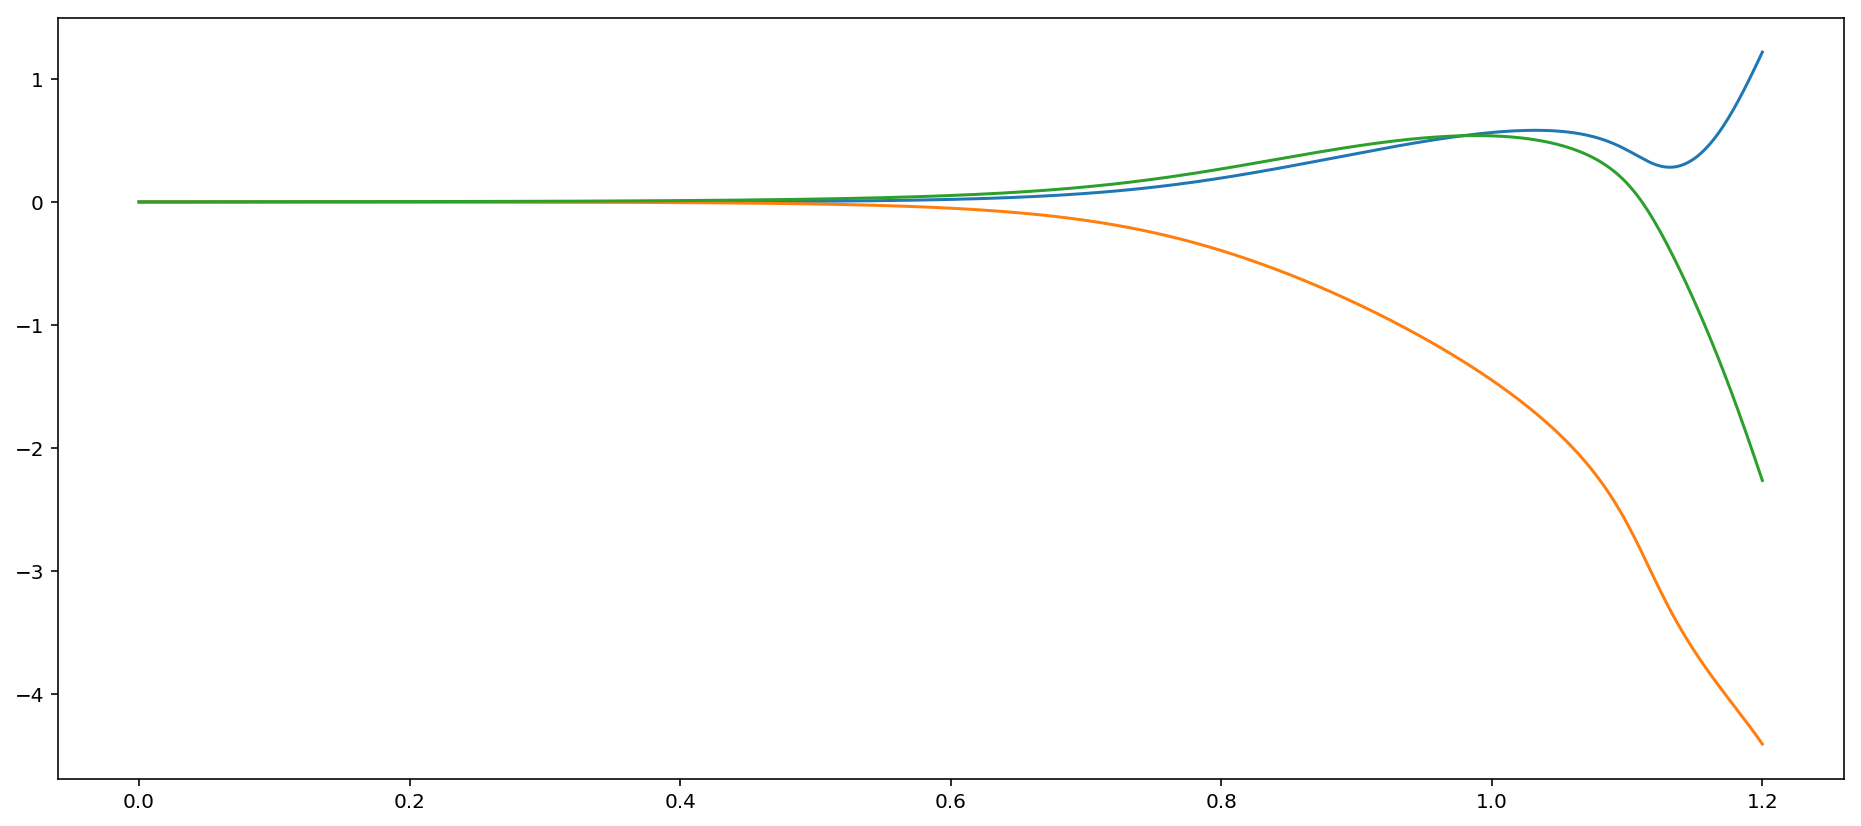

In [82]:
phi_1 = solution[:, 0]
phi_2 = solution[:, 1]
phi_3 = solution[:, 2]
plot(t, phi_1)
plot(t, phi_2)
plot(t, phi_3);